In [39]:
import torch
import torch.nn as nn
from facenet_pytorch import InceptionResnetV1
from PIL import Image
import numpy as np
import os
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import json


In [42]:
with open("../models/label_map.json", "r") as f:
    label_map = json.load(f)

label_map = {int(k): v for k, v in label_map.items()}

num_classes = len(label_map)
print("Total Classes:", num_classes)


Total Classes: 69


In [43]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

facenet = InceptionResnetV1(pretrained="vggface2").eval().to(device)

classifier = nn.Linear(512, num_classes).to(device)
classifier.load_state_dict(torch.load("../models/facenet_best.pth", map_location=device))
classifier.eval()


Linear(in_features=512, out_features=69, bias=True)

In [44]:
def preprocess_image(img_path):
    img = Image.open(img_path).convert("RGB")
    img = img.resize((160, 160))
    img_np = np.asarray(img).astype(np.float32)
    img_np = (img_np - 127.5) / 128.0
    img_tensor = torch.tensor(img_np).permute(2, 0, 1).unsqueeze(0).to(device)
    return img_tensor

def predict(img_tensor):
    with torch.no_grad():
        emb = facenet(img_tensor)
        logits = classifier(emb)
        probs = torch.softmax(logits, dim=1)
        pred_idx = torch.argmax(probs).item()
        return pred_idx


In [49]:
TEST_DIR = "../data/test"

y_true = []
y_pred = []

for cls_name in os.listdir(TEST_DIR):
    class_dir = os.path.join(TEST_DIR, cls_name)
    if not os.path.isdir(class_dir):
        continue

    # Ambil index berdasarkan nama
    class_idx = None
    for k, v in label_map.items():
        if v == cls_name:
            class_idx = k
            break

    if class_idx is None:
        print("Folder tidak cocok dengan label_map:", cls_name)
        continue

    for img_file in os.listdir(class_dir):
        img_path = os.path.join(class_dir, img_file)

        try:
            img_tensor = preprocess_image(img_path)
            pred = predict(img_tensor)

            y_true.append(class_idx)
            y_pred.append(pred)
        except:
            print("Error reading:", img_path)


In [50]:
import numpy as np

unique_classes = np.unique(y_true)
print("Classes present in test:", len(unique_classes))

target_names = [label_map[int(i)] for i in unique_classes]


Classes present in test: 69


In [56]:
report = classification_report(
    y_true, 
    y_pred, 
    labels=unique_classes, 
    target_names=target_names,
    zero_division=0
)

print(report)

# Simpan ke file
with open("test_report.txt", "w") as f:
    f.write(report)

print("Report saved → test_report.txt")



                                 precision    recall  f1-score   support

           Abraham Ganda Napitu       0.00      0.00      0.00         1
       Abu Bakar Siddiq Siregar       0.00      0.00      0.00         1
             Ahmad Faqih Hasani       0.00      0.00      0.00         1
                   Aldi Sanjaya       0.00      0.00      0.00         1
                        Alfajar       0.00      0.00      0.00         1
            Alief Fathur Rahman       0.00      0.00      0.00         1
 Arkan Hariz Chandrawinata Liem       0.00      0.00      0.00         1
               Bayu Ega Ferdana       0.00      0.00      0.00         1
          Bayu Prameswara Haris       0.00      0.00      0.00         1
           Bezalel Samuel Manik       0.00      0.00      0.00         1
           Bintang Fikri Fauzan       0.00      0.00      0.00         1
              Boy Sandro Sigiro       0.00      0.00      0.00         1
             Desty Ananta Purba       0.00      0.

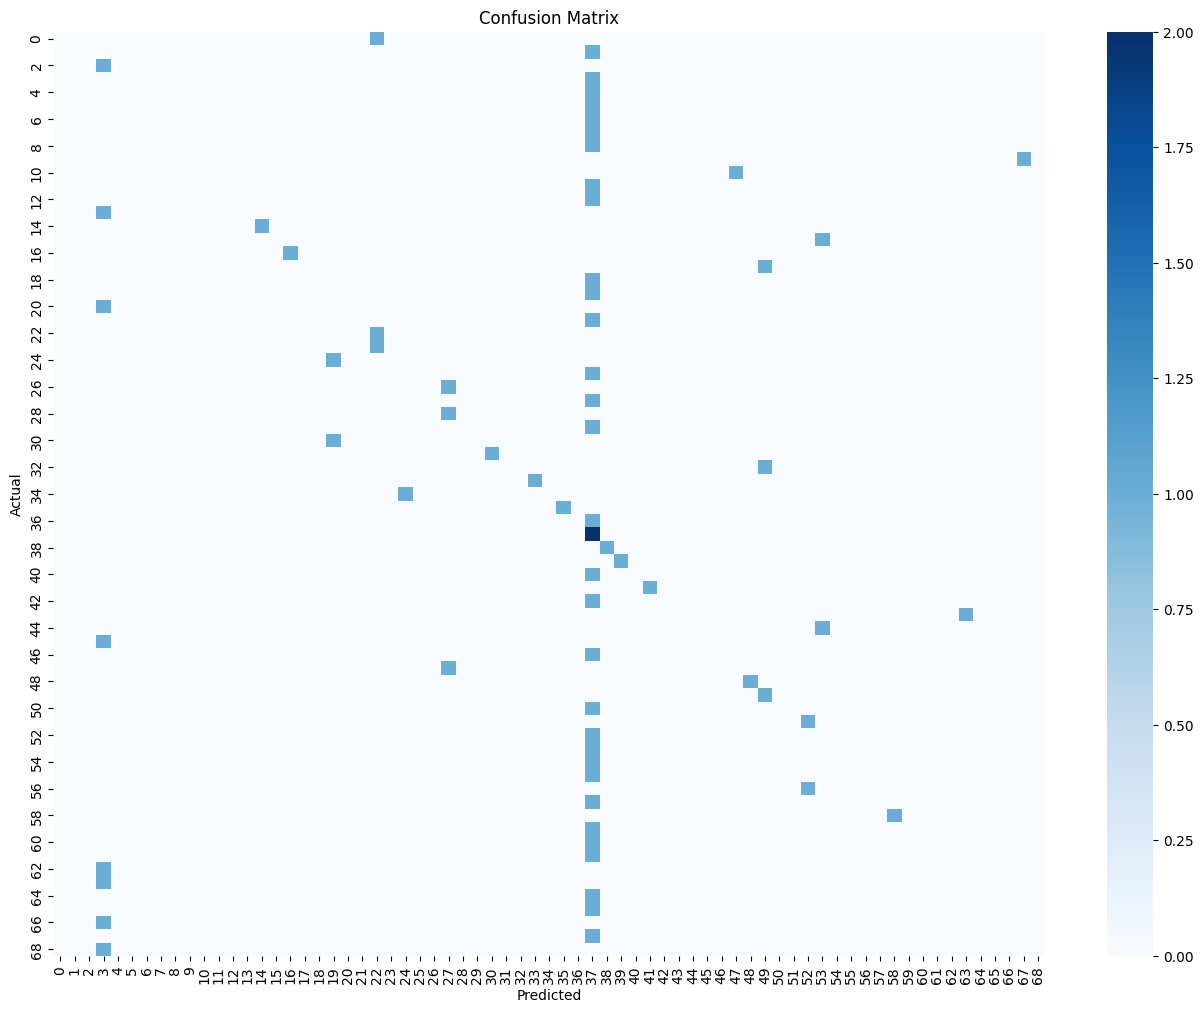

In [57]:
cm = confusion_matrix(y_true, y_pred, labels=unique_classes)

plt.figure(figsize=(16, 12))
sns.heatmap(cm, annot=False, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()
